## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [11]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
train, test = keras.datasets.cifar10.load_data()

In [13]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [14]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [21]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4.,ce_weights_list=0):
    
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
#         combined_loss = (1-ce_weights_list)*f1 + ce_weights_list*ce
        reduced_fl = tf.reduce_max(fl, axis=1)
        reduced_ce = tf.reduce_max(ce, axis=1)
        return tf.reduce_mean((1-ce_weights_list) * reduced_fl + ce_weights_list * reduced_ce)
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [22]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weights_list=ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (

Epoch 11/25
50000/50000 [==============================] - 6s 121us/step - loss: 2.2004 - accuracy: 0.6211 - val_loss: 3.1966 - val_accuracy: 0.4823
Epoch 12/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.1067 - accuracy: 0.6374 - val_loss: 3.2073 - val_accuracy: 0.4855
Epoch 13/25
50000/50000 [==============================] - 6s 120us/step - loss: 2.0103 - accuracy: 0.6472 - val_loss: 3.3671 - val_accuracy: 0.4599
Epoch 14/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.9226 - accuracy: 0.6628 - val_loss: 3.2716 - val_accuracy: 0.4784
Epoch 15/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.8267 - accuracy: 0.6755 - val_loss: 3.2261 - val_accuracy: 0.4813
Epoch 16/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.7425 - accuracy: 0.6914 - val_loss: 3.2512 - val_accuracy: 0.4905
Epoch 17/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.6630 - accuracy: 0.7007

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 149us/step - loss: 3.4512 - accuracy: 0.2980 - val_loss: 3.3968 - val_accuracy: 0.2007
Epoch 2/25
50000/50000 [==============================] - 6s 129us/step - loss: 2.5886 - accuracy: 0.4172 - val_loss: 3.0551 - val_accuracy: 0.2920
Epoch 3/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.3628 - accuracy: 0.4613 - val_loss: 2.7496 - val_accuracy: 0.3907
Epoch 4/25
50000/50000 [==============================] - 6s 121us/step - loss: 2.2266 - accuracy: 0.4899 - val_loss: 2.5577 - val_accuracy: 0.4296
Epoch 5/25
50000/50000 [==============================] - 6s 122us/step - loss: 2.1243 - accuracy: 0.5086 - val_loss: 2.4157 - val_accuracy: 0.4471
Epoch 6/25
50000/50000 [==============================] - 6s 120us/step - loss: 2.0356 - accuracy: 0.5265 - val_loss: 2.3303 - val_accuracy: 0.4659
Epoch 7/25
50000/50000 [==============================] - 6s 1

Epoch 21/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.0573 - accuracy: 0.6404 - val_loss: 1.4614 - val_accuracy: 0.4901
Epoch 22/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.0358 - accuracy: 0.6483 - val_loss: 1.4589 - val_accuracy: 0.4895
Epoch 23/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.0155 - accuracy: 0.6543 - val_loss: 1.4568 - val_accuracy: 0.4892
Epoch 24/25
50000/50000 [==============================] - 9s 174us/step - loss: 0.9947 - accuracy: 0.6638 - val_loss: 1.4552 - val_accuracy: 0.4946
Epoch 25/25
50000/50000 [==============================] - 8s 166us/step - loss: 0.9751 - accuracy: 0.6720 - val_loss: 1.4603 - val_accuracy: 0.4921


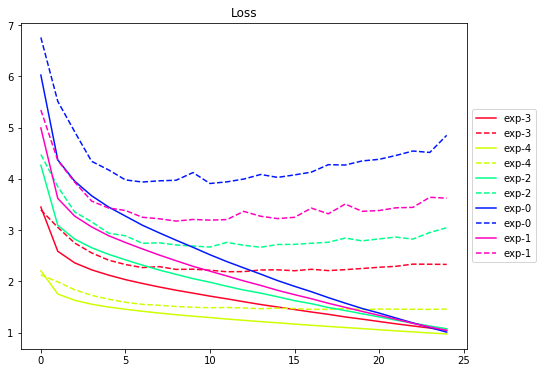

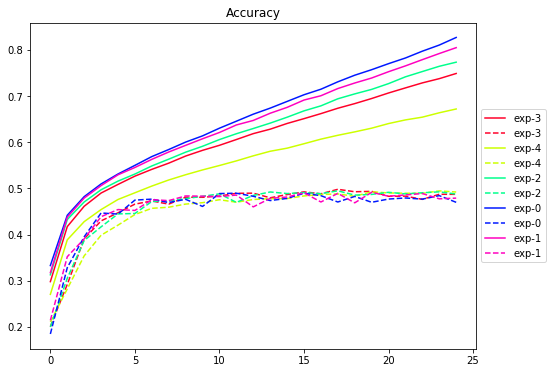

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()